In [96]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

sys.path.append('../')

In [12]:
def get_bet_results(row):
    
    if row['bet_winner'] == 1:
        if row['model_w_pred'] > 0.5:
            return (150 * row['psw']) - 150
        else:
            return (50 * row['psw']) - 50
        
    if row['bet_loser'] == 1:
        if row['model_l_pred'] > 0.5:
            return -150
        else:
            return -150
    else:
        return 0

In [54]:
years = ['2021.xlsx', '2022.xlsx', '2023.xlsx']

folder = '../tennis_betting_data/'

betting_df = pd.DataFrame()

for year in years:
    df_ = pd.read_excel(f'{folder}{year}')
    betting_df = pd.concat([betting_df, df_])
    
betting_df['date_monday'] = betting_df['Date'] - pd.offsets.Week(weekday=0)
betting_df['winner_last_name'] = [x.split()[0] for x in betting_df.Winner]
betting_df['loser_last_name'] = [x.split()[0] for x in betting_df.Loser]

betting_df.drop(columns='Surface', inplace=True)

In [99]:
assess_df = pd.read_csv(f'{folder}betting_assess_df.csv', low_memory=False, parse_dates=['tourney_date'])
assess_df.rename(columns={'Unnamed: 0' : 'match'}, inplace=True)

assess_df['player_one_winner'] = np.where(assess_df['player_one'] == assess_df['winner_id'], 1, 0)
assess_df['winner_last_name'] = [x.split()[-1] for x in assess_df.winner_name]
assess_df['loser_last_name'] = [x.split()[-1] for x in assess_df.loser_name]
assess_df['season'] = assess_df['tourney_date'].dt.year

DATE_MINIMUM = '2020-01-01'

assess_df = assess_df[assess_df['tourney_date'] >= DATE_MINIMUM].copy()

In [103]:
# creating the trial dataframe to test our model

trial = assess_df.merge(betting_df, how='left', left_on=['tourney_date', 'winner_last_name', 'loser_last_name'],
                 right_on=['date_monday', 'winner_last_name', 'loser_last_name'])

trial = trial[~trial['date_monday'].isnull()]
trial.columns = trial.columns.str.lower()

# calculating odds with and without vigorish for the average price
trial['avg_vegas_pred_w'] = 1 / trial['avgw']
trial['avg_vegas_pred_l'] = 1 / trial['avgl']
trial['avg_overround'] = trial[['avg_vegas_pred_w', 'avg_vegas_pred_l']].sum(axis=1)
trial['avg_w_no_vig'] = trial['avg_vegas_pred_w'].div(trial['avg_overround'])
trial['avg_l_no_vig'] = trial['avg_vegas_pred_l'].div(trial['avg_overround'])

# calculating odds with and without vigorish for pinnacle
trial['pinnacle_vegas_pred_w'] = 1 / trial['psw']
trial['pinnacle_vegas_pred_l'] = 1 / trial['psl']
trial['pinnacle_overround'] = trial[['pinnacle_vegas_pred_w', 'pinnacle_vegas_pred_l']].sum(axis=1)
trial['pinnacle_w_no_vig'] = trial['pinnacle_vegas_pred_w'].div(trial['pinnacle_overround'])
trial['pinnacle_l_no_vig'] = trial['pinnacle_vegas_pred_l'].div(trial['pinnacle_overround'])

# converting the model predictions to winner and loser predictions
trial['model_w_pred'] = np.where(trial['player_one_winner'] == 1,
                                 trial['model_pred'],
                                 1 - trial['model_pred'])

trial['model_l_pred'] = 1 - trial['model_w_pred']

# calculating the minimum odds needed to bet with
trial['min_odds_winner'] = (1 + (1 - trial['model_w_pred']) / trial['model_w_pred']) * 1.1
trial['min_odds_loser'] = (1 + (1 - trial['model_l_pred']) / trial['model_l_pred']) * 1.1

trial['bet_winner'] = ((trial['model_w_pred'] - trial['pinnacle_vegas_pred_w']) >= 0.04).astype(int)
trial['bet_loser'] = ((trial['model_l_pred'] - trial['pinnacle_vegas_pred_l']) >= 0.04).astype(int)

# dropping all rows where we don't have a vegas prediction
trial = trial[~trial['avg_vegas_pred_w'].isnull()].copy()
trial = trial[~trial['pinnacle_vegas_pred_w'].isnull()].copy()
trial = trial[trial['pinnacle_vegas_pred_w'].between(0, 1)].copy()
trial = trial[trial['avg_overround'].between(1, 1.07)].copy()
trial = trial[trial['pinnacle_overround'].between(1, 1.03)].copy()

print(trial.shape)

(3222, 156)


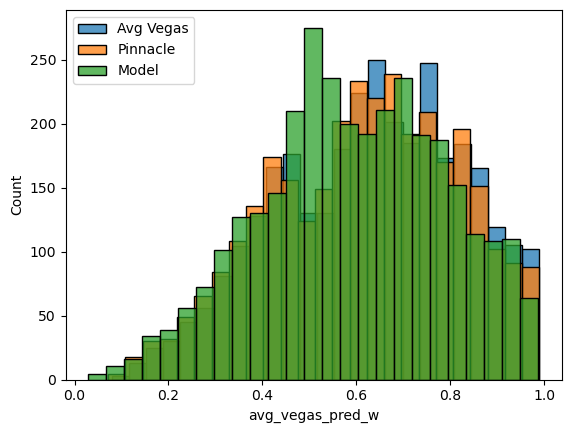

In [104]:
sns.histplot(trial['avg_vegas_pred_w'], bins=25, label='Avg Vegas')
sns.histplot(trial['pinnacle_vegas_pred_w'], bins=25, label='Pinnacle')
sns.histplot(trial['model_w_pred'], bins=25, label='Model')

plt.legend()
plt.show()

In [111]:
trial['bet_winner'] = ((trial['model_w_pred'] - trial['pinnacle_vegas_pred_w']) >= 0.05).astype(int)
trial['bet_loser'] = ((trial['model_l_pred'] - trial['pinnacle_vegas_pred_l']) >= 0.05).astype(int)

trial['bet_results'] = trial.apply(get_bet_results, axis=1)

print("we made", trial['bet_winner'].sum() + trial['bet_loser'].sum(), "bets")
print("we won", trial['bet_results'].sum())

we made 1265 bets
we won -42823.5


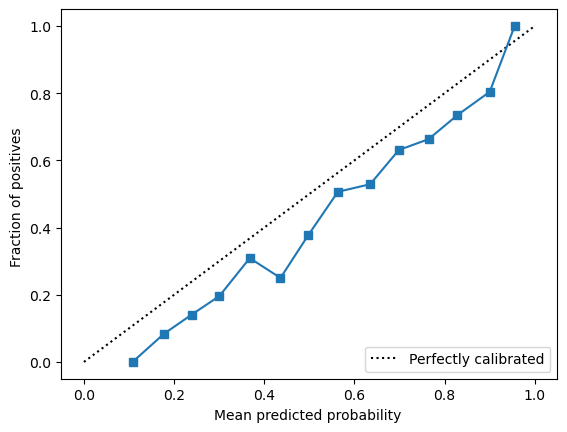

In [112]:
# reshaping the bets data and displaying the calibration curve
# as can be seen, the model is horribly miscalibrated on
# the bets
bets_reshaped = (
    pd.concat([
        trial[trial['bet_loser'] == 1][['model_l_pred']].assign(win=0).rename(columns={'model_l_pred' : 'model_pred'}),
        trial[trial['bet_winner'] == 1][['model_w_pred']].assign(win=1).rename(columns={'model_w_pred' : 'model_pred'})],
        axis=0)
)

y_prob = bets_reshaped['model_pred'].values
prob_true, prob_pred = calibration_curve(bets_reshaped['win'], bets_reshaped['model_pred'], n_bins=15)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)

disp.plot()